# Example Backtests

Here we have two examples of backtests ran within the developed framework, both making use of the backtester. Both are built on a similar mathematical model, and both make use of the algorithm CAPA cc, which detects changes in correlation of time series. 

One is market neutral, the other is a mean reversion strategy which takes sector-wide directional bets.  

In [1]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np
import sys
sys.path.append('..')

In [2]:
# backtest engine and strategies
from backtester import Orchestrator
from algorithms.TradingStrategy import TradingLogic 

In [3]:
# for testing purposes, we will use data from quantum computing companies. 
dataset = pd.read_csv('../data/qtm_data.csv', index_col = 'Datetime')
equal_weighted_index = dataset.sum(axis=1)
normed_index = (equal_weighted_index - equal_weighted_index.iloc[0]) 

Data availability can be an issue for these backtests. The data provider I have been using is yfinance, and they offer data going backwards one week at the required resolution (minute by minute). Currently I have a bash script which automates the process of pulling the data for the previous trading day for me every morning. This is hosted on Lancaster Universities provided virtual machines. 

## Algorithm 1

In this algorithm, we presume that breakouts will mean revert. Breakouts are categorised as anomalously large residuals, all of shared signs, on principal components. Hence, again they are detected with the same algorithm for detecting changes in correlations in time series. 

best params derived from backtest: 
- alpha = 0.4
- pcs_removed = 1 
- unwind_rate = 20
- sensitivity = 0.01
- min_len = 13

For this strategy, it pays to have only the most correlated stocks featured. Hence, we trim the data set to only include very highly correlated assets 

In [4]:
dataset_trimmed = dataset[['IONQ', 'QBTS','RGTI']]
equal_weighted_index_trimmed = dataset_trimmed.sum(axis=1)
normed_index_trimmed = (equal_weighted_index_trimmed - equal_weighted_index_trimmed.iloc[0]) 

In [5]:
outs_mean_rev = Orchestrator(
    TradingLogic,
    start_time="2025-08-05 14:30:00+00:00", 
    dataset = dataset_trimmed,
    alpha = 0.4, 
    remove_pcs = False, 
    pcs_removed = 1,
    slippage = 1,
    unwind_rate=20, 
    sensitivity=0.01, 
    min_len=13, 
    bt_res=1
    ).RunOrchestrator() 

print('Pnl from run:',outs_mean_rev[1].iloc[-1])

Pnl from run: 28.28303596300774


In [6]:
# make a df which allows us to offset some of the position vs time plots 
diff_mean_rev = max(0, len(outs_mean_rev[1]) - len(outs_mean_rev[0]))
offsets_mean_rev = pd.DataFrame(
    0,
    index=pd.RangeIndex(diff_mean_rev),
    columns=outs_mean_rev[0].columns
)
log_df_mean_rev = pd.concat([offsets_mean_rev, outs_mean_rev[0]], axis=0)

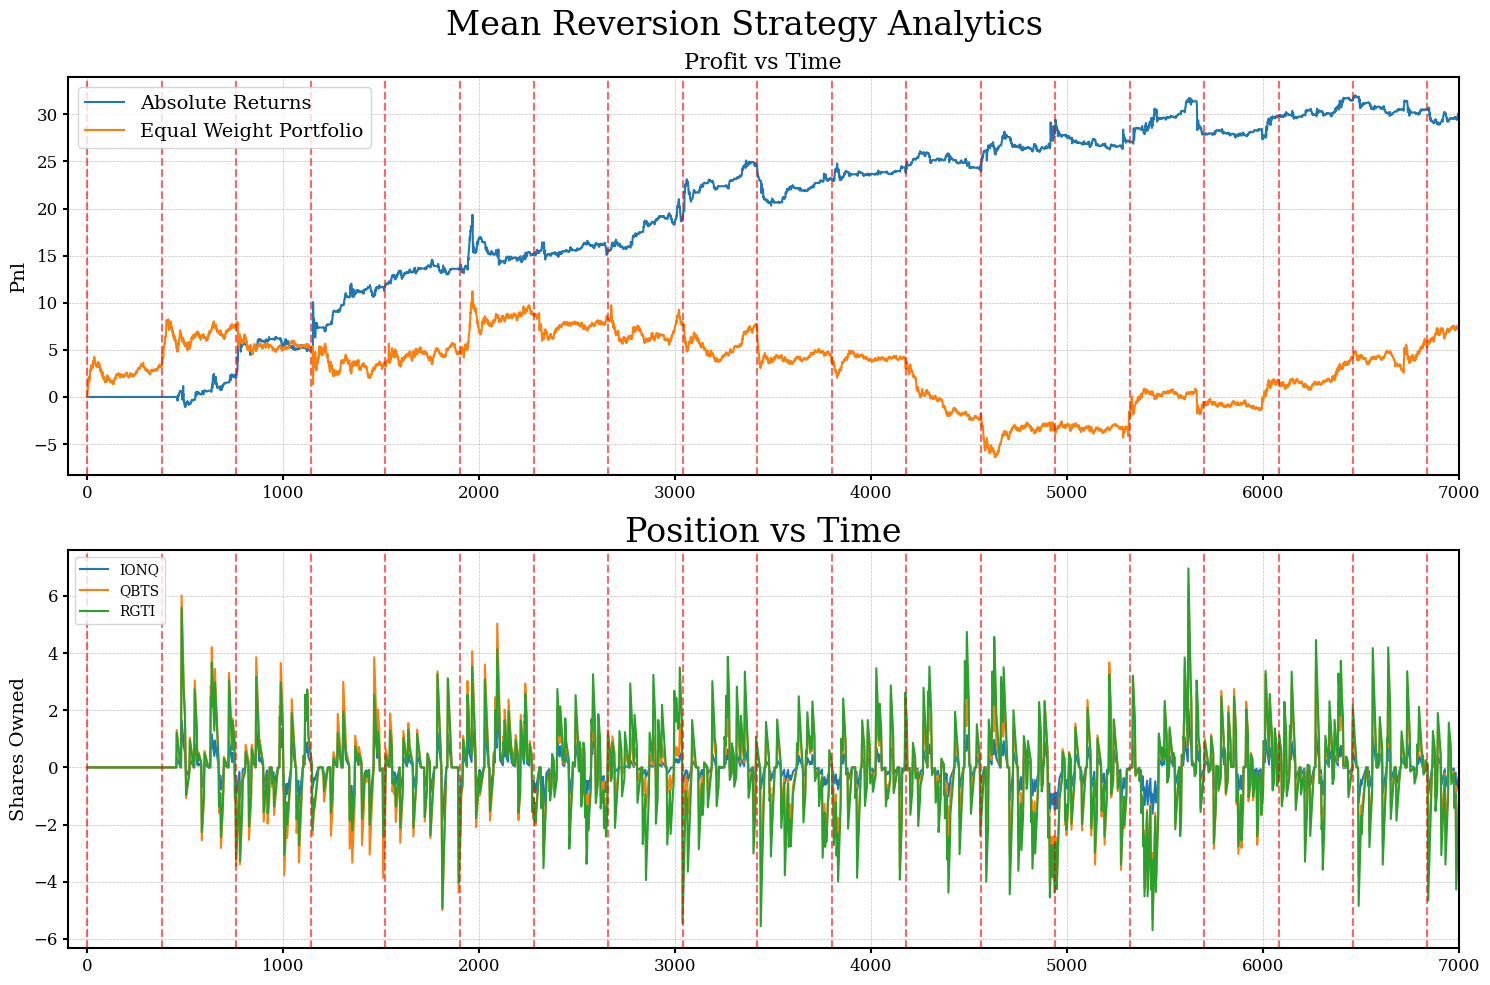

In [14]:
daybreaks = [380 * i for i in range(70)]
fig, axes = plt.subplots(2, figsize=(15,10))
fig.suptitle('Mean Reversion Strategy Analytics', fontsize = 24)
axes[0].plot(range(0, len(outs_mean_rev[1])), outs_mean_rev[1], label = 'Absolute Returns')
axes[0].plot(normed_index_trimmed.values, label = 'Equal Weight Portfolio')
axes[0].set_title('Profit vs Time')
axes[0].set_ylabel('Pnl')
axes[0].legend(fontsize = 14, loc = 'upper left')

positions_mean_rev = log_df_mean_rev.cumsum()
axes[1].plot(range(0, len(positions_mean_rev)), positions_mean_rev, label = log_df_mean_rev.columns)
axes[1].set_title('Position vs Time', fontsize = 24)
axes[1].set_ylabel('Shares Owned')
axes[1].legend(loc = 'upper left')

axes = axes.flatten()
for ax in axes:
    for dbreak in daybreaks:
        ax.axvline(dbreak, color = 'red', linestyle = '--', alpha = 0.6)
        ax.set_xlim((-100, 7000))
fig.tight_layout()
plt.savefig('mean_rev_strat.png')
plt.show()

In [8]:
# some information on total transactions to get there 
costs_mean_rev = np.abs(log_df_mean_rev) # type: ignore
net_per_stock_mean_rev = costs_mean_rev.sum(axis=0).values
transactions_mean_rev = sum(net_per_stock_mean_rev * dataset_trimmed.iloc[-1])
transactions_mean_rev, outs_mean_rev[1].iloc[-1]/ transactions_mean_rev * 100

(56643.94626232767, np.float64(0.049931259789041234))

## Algorithm 2

Market neutral strategy in which we bet on reconvergence after periods of negative correlation. This is in keeping with what we defined as the objective in section 4.2 of the report. 

best params derived from backtest: 
- alpha = 0.7
- pcs_removed = 1
- unwind_rate = 8
- sensitivity = 0.001
- min_len =  12

In [9]:
outs_market_neutral = Orchestrator(
    TradingLogic,
    start_time="2025-08-05 14:30:00+00:00", 
    dataset = dataset,
    alpha = 0.7, 
    remove_pcs = True, 
    pcs_removed = 1,
    slippage = 1,
    unwind_rate=8, 
    sensitivity=0.001, 
    min_len=12, 
    bt_res=1
    ).RunOrchestrator() 

print('Pnl from run:',outs_market_neutral[1].iloc[-1])

Pnl from run: 2.9027972771004444


In [10]:
# make a df which allows us to offset some of the position vs time plots 
diff_market_neutral = max(0, len(outs_market_neutral[1]) - len(outs_market_neutral[0]))
offsets_market_neutral = pd.DataFrame(
    0,
    index=pd.RangeIndex(diff_market_neutral),
    columns=outs_market_neutral[0].columns
)
log_df_market_neutral = pd.concat([offsets_market_neutral, outs_market_neutral[0]], axis=0)

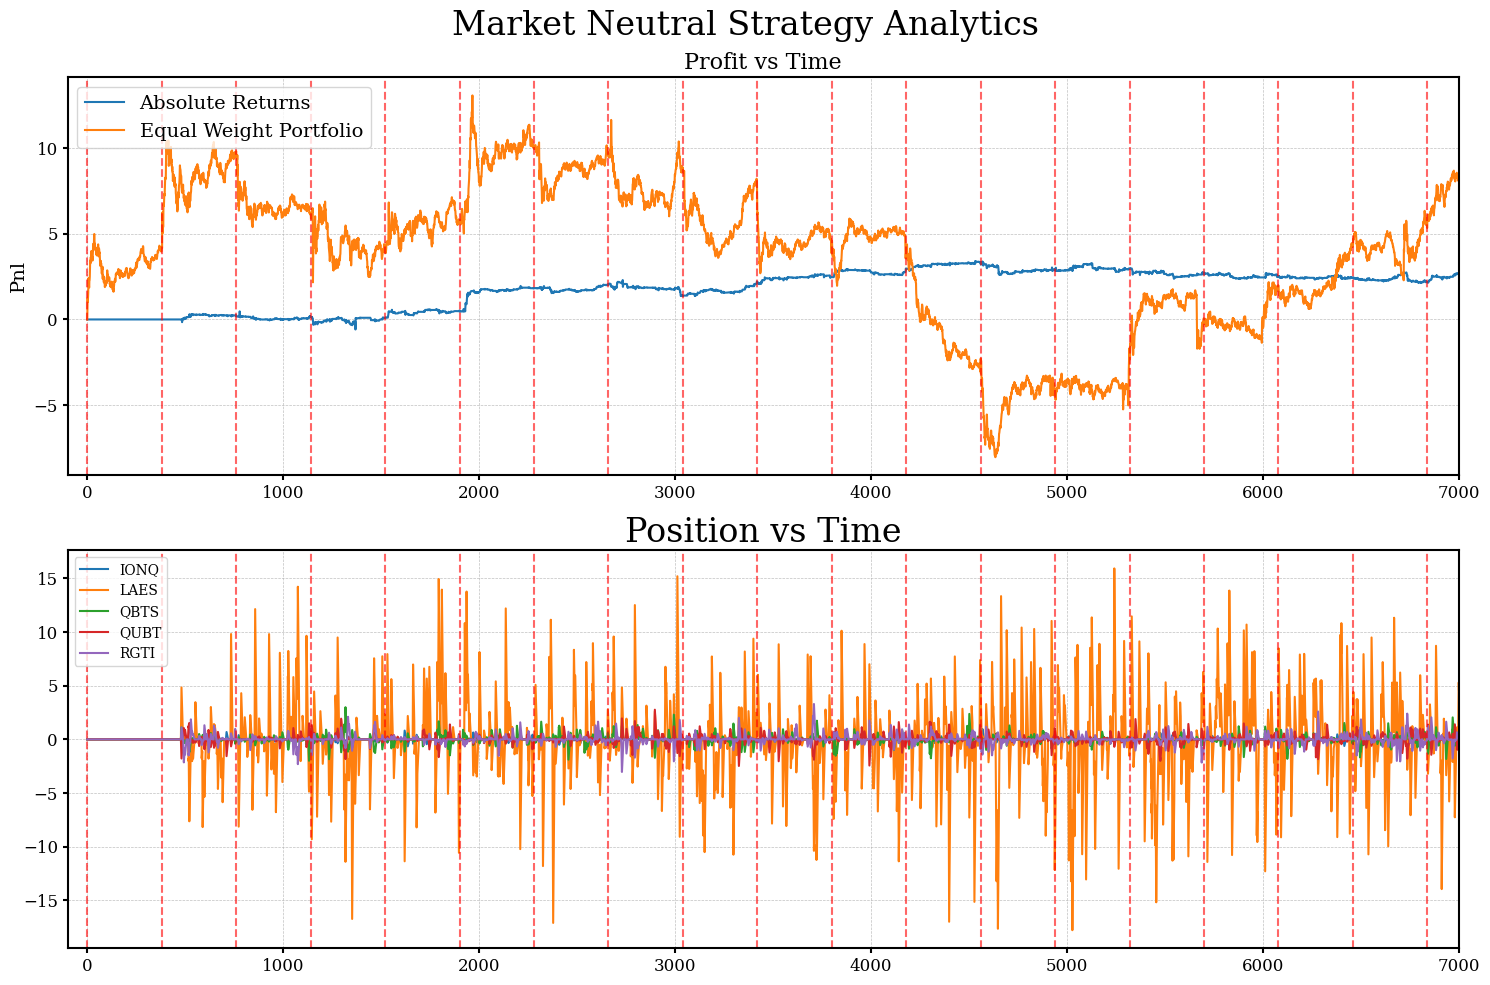

In [11]:
daybreaks = [380 * i for i in range(70)]
fig, axes = plt.subplots(2, figsize=(15,10))
fig.suptitle('Market Neutral Strategy Analytics', fontsize = 24)
axes[0].plot(range(0, len(outs_market_neutral[1])), outs_market_neutral[1], label = 'Absolute Returns')
axes[0].plot(normed_index.values, label = 'Equal Weight Portfolio')
axes[0].set_title('Profit vs Time')
axes[0].set_ylabel('Pnl')
axes[0].legend(fontsize = 14, loc = 'upper left')

positions_market_neutral = log_df_market_neutral.cumsum()
axes[1].plot(range(0, len(positions_market_neutral)), positions_market_neutral, label = log_df_market_neutral.columns)
axes[1].set_title('Position vs Time', fontsize = 24)
axes[1].legend(loc = 'upper left')

axes = axes.flatten()
for ax in axes:
    for dbreak in daybreaks:
        ax.axvline(dbreak, color = 'red', linestyle = '--', alpha = 0.6)
        ax.set_xlim((-100, 7000))
fig.tight_layout()
plt.show()

In [12]:
# some information on total transactions to get there 
costs_market_neutral = np.abs(log_df_market_neutral) # type: ignore
net_per_stock_market_netral = costs_market_neutral.sum(axis=0).values
transactions_market_neutral = sum(net_per_stock_market_netral * dataset.iloc[-1])
transactions_market_neutral, outs_market_neutral[1].iloc[-1]/ transactions_market_neutral * 100

(43181.60421879285, np.float64(0.006722300687099375))

The edge acquired for this strategy is particularly small, and certainly narrower than the spreads on these stocks. 